In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *

import pickle

sys.path.append("..")
import readseq
import ulmputils

seqDirPath = Config().data_path()/'pseq'

This notebook processes entries from the Swissprot database into datasets for our models. It assumes the swissprot database has been downloaded in text format from https://www.uniprot.org/downloads and decompressed and saved to the seqDirPath directory.

In [3]:
datFPath = seqDirPath/'uniprot_sprot.dat'
lmFilterPars = dict(
    skipUndet = True,
    skipPyl = True,
    minLen = 40,
    maxLen = 500,
    maxPE = 3,
    requireInName='',
    excludeStrs = ['fragment'],
)
clusterLen = 30

In [4]:
print('Stats:')
print('all organisms, all PE:')
readseq.makeLMDataset(datFPath,lmFilterPars,maxPE=5);
print('all organisms, PE<=3:')
seqM = readseq.makeLMDataset(datFPath,lmFilterPars,maxPE=3);
print('human, all PE:')
readseq.makeLMDataset(datFPath,lmFilterPars,maxPE=5,requireInOS='homo sapiens');
print('human, PE<=3:')
readseq.makeLMDataset(datFPath,lmFilterPars,maxPE=3,requireInOS='homo sapiens');

Stats:
all organisms, all PE:
total length 112,142,558 in 437,134 sequences; 21 letters: ACDEFGHIKLMNPQRSTUVWY
all organisms, PE<=3:
total length 109,617,240 in 423,957 sequences; 21 letters: ACDEFGHIKLMNPQRSTUVWY
human, all PE:
total length 3,482,136 in 12,287 sequences; 21 letters: ACDEFGHIKLMNPQRSTUVWY
human, PE<=3:
total length 3,353,716 in 11,620 sequences; 21 letters: ACDEFGHIKLMNPQRSTUVWY


In [5]:
aaFreqs = sorted(readseq.cCounts(seqM.values()).items(), key=lambda x:x[1])
print('Amino acid frequencies:')
for aaLet,freq in aaFreqs :
    print('{}: {:,}'.format(aaLet,freq))

Amino acid frequencies:
U: 289
W: 1,164,030
C: 1,459,316
H: 2,480,873
M: 2,777,797
Y: 3,154,588
Q: 4,073,212
N: 4,196,086
F: 4,235,456
P: 4,953,227
T: 5,752,494
D: 5,917,458
R: 6,172,081
K: 6,350,756
S: 6,648,585
I: 6,732,226
E: 7,220,784
V: 7,849,836
G: 8,137,174
A: 9,654,120
L: 10,686,852


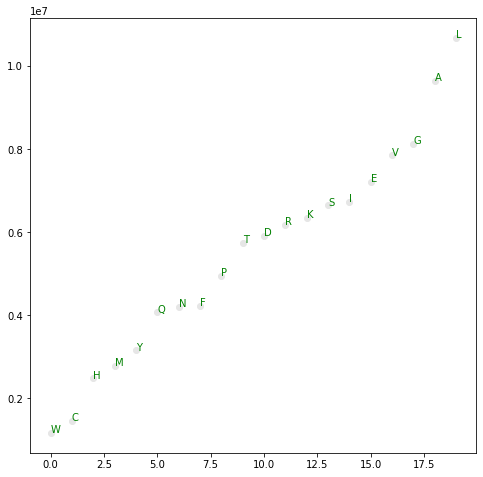

In [6]:
plt.figure(figsize=(8,8))
plt.scatter(range(20), [freq for _,freq in aaFreqs[1:]],color=(0.9,0.9,0.9))
for i,(aaLet,freq) in enumerate(aaFreqs[1:]) :
    plt.text(i,freq,aaLet,color='green')
plt.show()

In [7]:
fName = 'swissprotPE3'
print('generating PE<=3 set, all organisms')
readseq.makeLMDataset(datFPath,lmFilterPars,seqDirPath/(fName+'.csv'),
                      seqDirPath/(fName+'clusters.csv'),clusterLen,
                      maxPE=3);

generating PE<=3 set, all organisms
total length 109,617,240 in 423,957 sequences; 21 letters: ACDEFGHIKLMNPQRSTUVWY
length-30 subsequences: total 97,322,487, unique 65,216,756
181,118 clusters; identifier counts: 423,957, 423,957


In [8]:
def makeClasDataset(trSetName,propFn,propKwArgs={},**kwargs) :
    print()
    print('Generating',trSetName,'dataset:')
    readseq.makeClasDataset(datFPath,seqDirPath/(fName+'clusters.csv'),
                            propFn,propKwArgs,
                            seqDirPath/(fName+trSetName+'Train.csv'),
                            seqDirPath/(fName+trSetName+'Test.csv'),
                            **kwargs)
for name,fn,nCopies in [
            ('atpBind',readseq.getDatAtpBinding,1),
            ('gtpBind',readseq.getDatGtpBinding,10),
            ('metalBind',readseq.getDatMetalBinding,3),
        ] :
    makeClasDataset(name,fn,nCopiesFn=readseq.dupPos(nCopies))
    print(readseq.countDat(datFPath,fn))


Generating atpBind dataset:
train: 317366 valid: 27268 test: 17884 skipped: 61439 clusters: 181118
Counter({'neg': 473231, 'pos': 88125})

Generating gtpBind dataset:
train: 317366 valid: 27268 test: 17884 skipped: 61439 clusters: 181118
Counter({'neg': 546803, 'pos': 14553})

Generating metalBind dataset:
train: 317366 valid: 27268 test: 17884 skipped: 61439 clusters: 181118
Counter({'neg': 505764, 'pos': 55592})
